[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building MoGs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation


## Load the package

Import **multimin** and other required libraries:

In [2]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

Welcome to MultiMin v0.10.3. ¡Al infinito y más allá!


## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [3]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

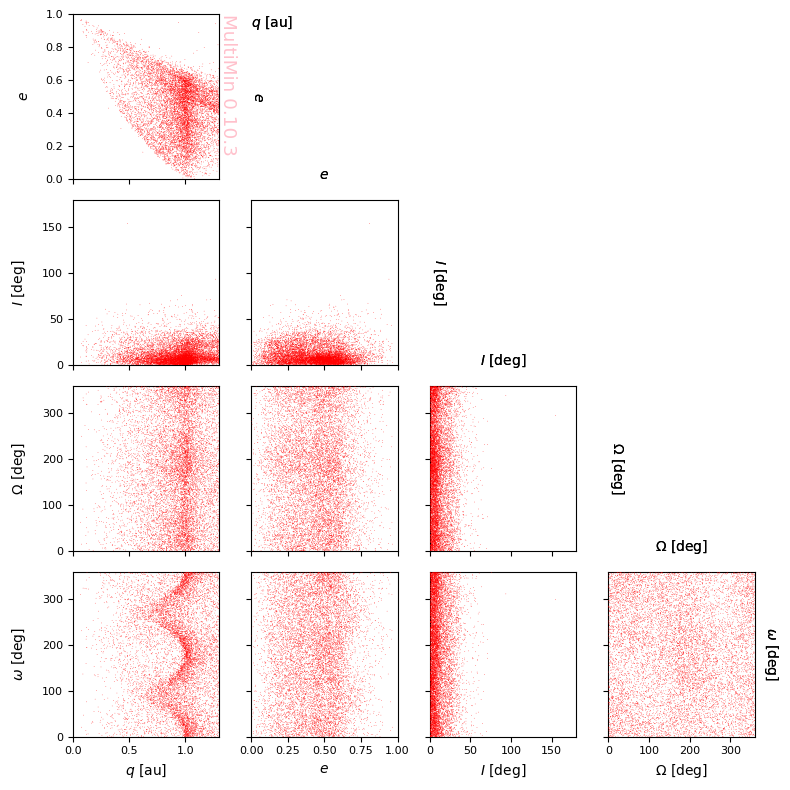

In [4]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.MultiPlot(properties,figsize=2)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


Or a colormesh:

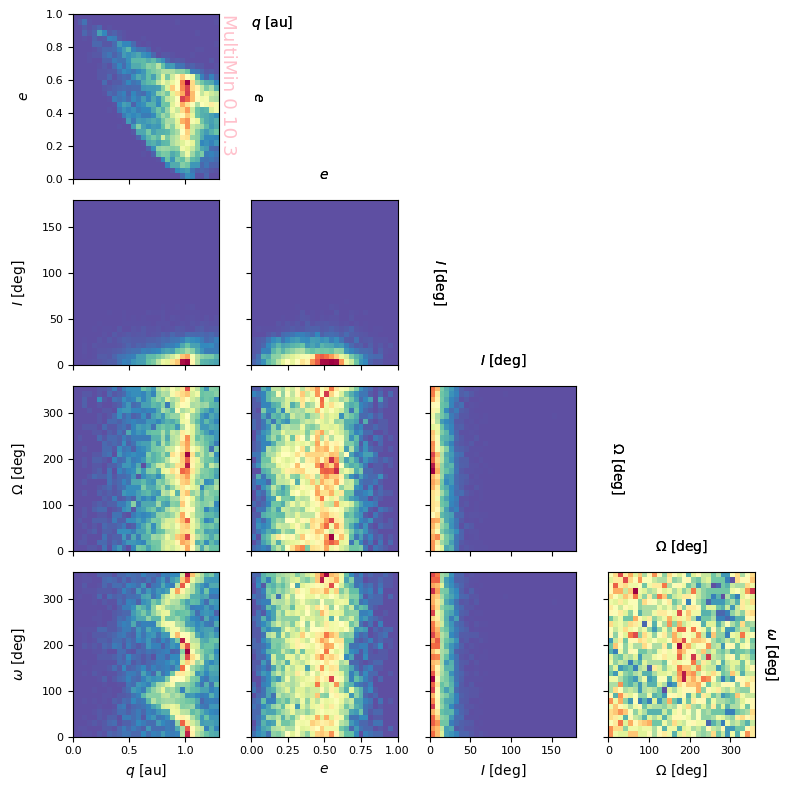

In [5]:
G=mn.MultiPlot(properties,figsize=2)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.sample_hist(data_neas,**hargs)
plt.savefig(f'gallery/{figprefix}_data_neas_hist.png')

### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [6]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

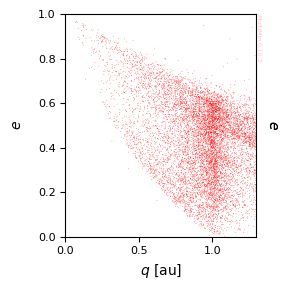

In [7]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')

Now we will proceed to fit the data against a singled truncated distribution:

In [8]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitMoG(data=data_neas_qe, ngauss=1, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(progress=False)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.306140151973535
FitMoG.fit_data executed in 0.12841176986694336 seconds
Elapsed time since last call: 136.439 ms
-log(L)/N = -0.5429374394116252


And check the fit result:

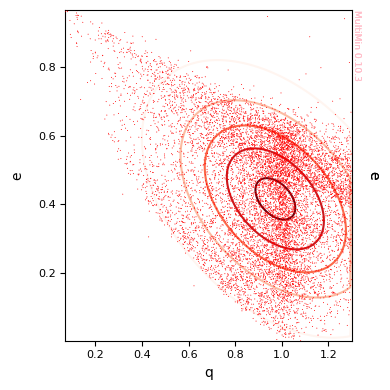

In [9]:
# properties: list of names or dict like MultiPlot (e.g. dict(q=dict(label=r"$q$", range=None), ...))
properties=["q","e"]
pargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
cargs=dict()
G=F_qe_1.plot_fit(
    properties=properties,
    #pargs=hargs,
    pargs=None,
    sargs=sargs,
    cargs=cargs,
    figsize=4
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [10]:
F_qe_1.mog.tabulate()

,w,mu_1,mu_2,sigma_1,sigma_2,rho_12
component,,,,,,
1,1.0,0.972251,0.41564,0.266957,0.188449,-0.434862


We can do it better increasing the number of normals:

In [11]:
t = mn.Util.el_time(0)
F = mn.FitMoG(data=data_neas_qe, ngauss=5, domain=[[0,1.3], [0, 1]])
F.fit_data(advance=50)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 2
Number of dimensions: 10
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.24560342266475862
Iterations:
Iter 0:
	Vars: [-1.5, -1.3, -1.3, -1.3, -1.5, 0.48, 0.14, 0.82, 0.32, 0.96, 0.45, 1, 0.55, 1.2, 0.71, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, 0.72, 0.63, 0.7, 0.42, 1.1]
	LogL/N: 2.090494806454566


Iter 50:
	Vars: [-2.1, -1.4, -0.93, -0.73, -1.8, 0.9, 0.18, 0.72, 0.37, 1, 0.35, 1.1, 0.51, 1, 0.53, -4.3, -4.9, -3.8, -4.1, -4.5, -4.5, -3.2, -4.1, -4.3, -4.8, -1.3, -1.9, -1.1, -3.5, 0.58]
	LogL/N: -0.6993458917009708


Iter 100:
	Vars: [-2.5, -2.6, -0.11, -0.26, -1.8, 0.85, 0.18, 0.57, 0.42, 0.98, 0.32, 1.2, 0.48, 1, 0.47, -4.4, -4.9, -4.3, -4.5, -4.2, -4.2, -3, -4, -5.5, -4.6, -1.6, -1.4, -0.72, -3.3, 0.27]
	LogL/N: -0.7077444948898334


Iter 150:
	Vars: [-2.4, -2.7, 0.079, -0.3, -1.9, 0.8, 0.2, 0.51, 0.46, 0.97, 0.36, 1.1, 0.51, 1, 0.34, -4.5, -4.9, -4.5, -4.5, -4.1, -4.2, -3.1, -4.1, -5.7, -4.1, -2, -1.5, -0.82, -3.3, 0.076]
	LogL/N: -0.7152009635910037


Iter 200:
	Vars: [-2.6, -3, 0.045, -0.23, -1.4, 0.79, 0.19, 0.49, 0.46, 0.96, 0.36, 1.2, 0.51, 1, 0.35, -4.3, -4.8, -4.5, -4.5, -3.9, -4.2, -3.1, -4.2, -5.5, -4.1, -2.7, -1.7, -0.91, -3.2, -0.34]
	LogL/N: -0.7178403496608545


Iter 250:
	Vars: [-2.5, -3.2, 0.018, -0.14, -1.3, 0.77, 0.2, 0.47, 0.47, 0.96, 0.35, 1.2, 0.5, 1, 0.35, -4.3, -4.7, -4.6, -4.7, -3.9, -4.2, -3.1, -4.1, -5.4, -4.1, -3.3, -1.9, -0.89, -3.2, -0.32]
	LogL/N: -0.7187612975619222


Iter 300:
	Vars: [-2.5, -3.4, 0.059, -0.12, -1.3, 0.77, 0.2, 0.46, 0.48, 0.95, 0.35, 1.2, 0.5, 1, 0.36, -4.2, -4.6, -4.6, -4.6, -3.9, -4.2, -3.1, -4.1, -5.4, -4.1, -3.5, -1.9, -0.99, -3.2, -0.18]
	LogL/N: -0.71908263596939


Iter 350:
	Vars: [-2.5, -3.4, 0.054, -0.12, -1.3, 0.76, 0.2, 0.46, 0.48, 0.95, 0.35, 1.2, 0.5, 1, 0.36, -4.2, -4.5, -4.6, -4.6, -3.9, -4.2, -3.1, -4.1, -5.4, -4.1, -3.5, -1.9, -0.98, -3.2, -0.14]
	LogL/N: -0.7191048446475201


Iter 400:
	Vars: [-2.2, -3.4, 0.06, -0.2, -1.4, 0.71, 0.25, 0.51, 0.55, 0.97, 0.35, 1.2, 0.51, 1, 0.36, -4, -4.3, -4.4, -4.6, -4, -4.2, -3.1, -4.1, -5.4, -4.1, -3.8, -1.6, -0.89, -3.3, 0.11]
	LogL/N: -0.7196982473365297


Iter 444:
	Vars: [-2.2, -3.2, 0.13, -0.25, -1.5, 0.71, 0.25, 0.51, 0.56, 0.97, 0.35, 1.2, 0.51, 1, 0.35, -3.9, -4.2, -4.3, -4.5, -4, -4.2, -3.1, -4.1, -5.5, -4.1, -3.9, -1.5, -0.71, -3.3, -0.22]
	LogL/N: -0.7203165443551935
FitMoG.fit_data executed in 20.56400203704834 seconds
Elapsed time since last call: 20.5666 s
-log(L)/N = -0.7203165443551935


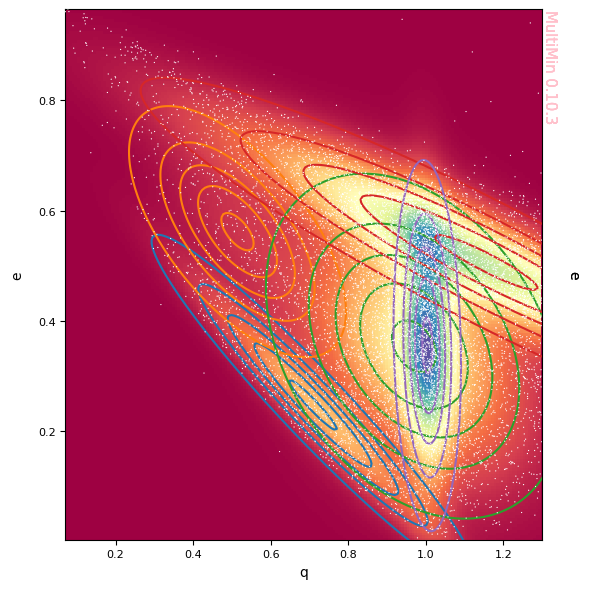

In [12]:
properties = ["q","e"]
sargs = dict(s=0.8,edgecolor='None',color='w')
pargs = dict(cmap='Spectral')
cargs = dict(decomp=True, legend=False)
G=F.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    cargs=cargs,
    figsize=6,
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_decomposition.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [13]:
neas_sample = F.mog.rvs(len(data_neas_qe))

MixtureOfGaussians.rvs executed in 0.6287717819213867 seconds


And plot it:

Text(0.5, 1.0, 'Original data')

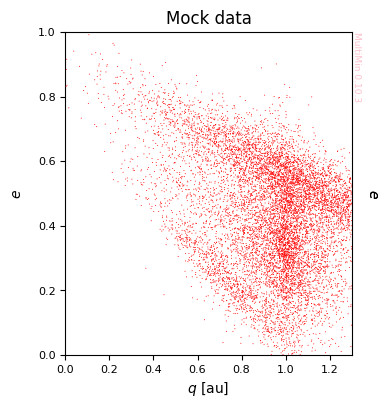

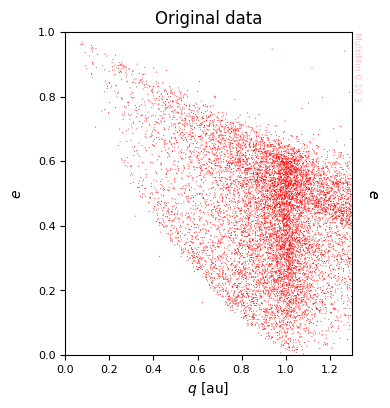

In [14]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.MultiPlot(properties,figsize=4)
G.sample_scatter(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.MultiPlot(properties,figsize=4)
scatter=G.sample_scatter(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [15]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.mog.tabulate(properties=properties)
table

,w,mu_q,mu_e,sigma_q,sigma_e,rho_qe
component,,,,,,
3,0.414056,0.969544,0.353824,0.177868,0.145921,-0.340283
4,0.340734,1.155834,0.505875,0.415288,0.156251,-0.931439
5,0.138453,1.003801,0.354780,0.040413,0.157050,-0.111691
1,0.077542,0.709082,0.246885,0.193977,0.144133,-0.961077
2,0.029215,0.514448,0.561776,0.130302,0.106211,-0.635253


In [16]:
function, mog = F.mog.get_function(properties=properties)

import numpy as np
from multimin import Util

def mog(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 0.709082
    mu1_e = 0.246885
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.037627, -0.02687], [-0.02687, 0.020774]]
    Z1 = 0.956506
    n1 = Util.tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 0.514448
    mu2_e = 0.561776
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.016979, -0.008792], [-0.008792, 0.011281]]
    Z2 = 0.999943
    n2 = Util.tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 0.969544
    mu3_e = 0.353824
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.031637, -0.008832], [-0.008832, 0.021293]]
    Z3 = 0.962008
    n3 = Util.tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 1.155834
    mu4_e = 0.505875
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.172464, -0.06044], [-0.06044, 0.024414]]
    Z4 = 0.632939
    n4 = Util.tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 1.003801
    mu5_e = 0.35478
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.001633, -0.000709], [-0.000709, 0.024665]]
    Z5 =

### Fitting other pair of properties

Fitting $q$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 180]]
Log-likelihood per point (-log L/N): 129.69827145270375
FitMoG.fit_data executed in 0.08846807479858398 seconds
-log(L)/N = 3.4593571952295004


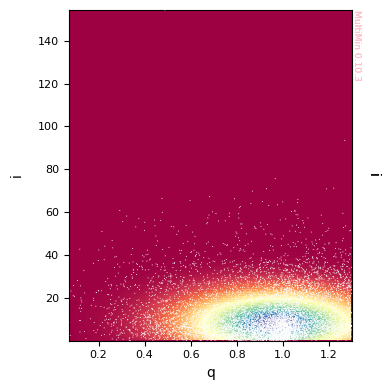

In [17]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitMoG(data=data_neas_qi, ngauss=1, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(progress=False)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

properties=["q","i"]
sargs=dict(s=0.5,edgecolor='None',color='w')
pargs=dict(cmap='Spectral')
G=F_qi_1.plot_fit(properties=properties,pargs=pargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1], [0, 180]]
Log-likelihood per point (-log L/N): 132.41867274367985
FitMoG.fit_data executed in 0.06355571746826172 seconds
-log(L)/N = 3.2846251854796726


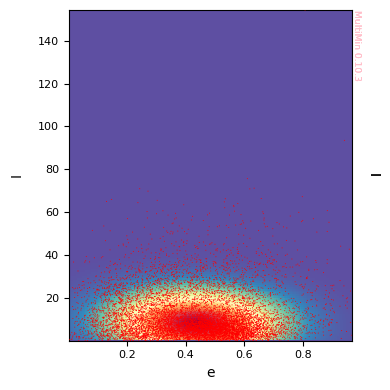

In [18]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitMoG(data=data_neas_ei, ngauss=1, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(progress=False)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

properties=["e","I"]
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(properties=properties,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [19]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

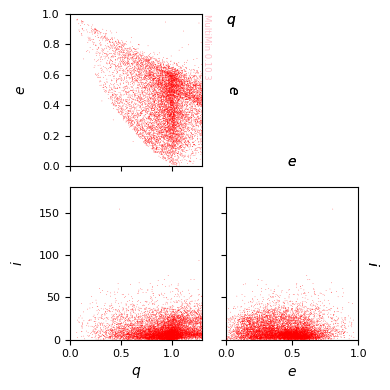

In [20]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.MultiPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.sample_scatter(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 142.3748823164863


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 1.037994146347046 seconds
-log(L)/N = -1.3034352981561506


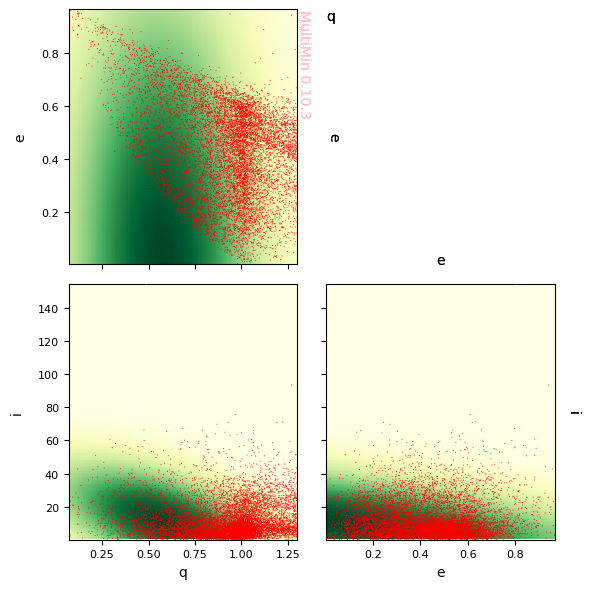

In [21]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    sargs=sargs,
    pargs=pargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

In [22]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.mog.mus[0, 0] + F_qi_1.mog.mus[0, 0]) / 2
mu_e = (F_qe_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 0]) / 2
mu_i = (F_qi_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 1]) / 2
sigma_q = (F_qe_1.mog.sigmas[0, 0] + F_qi_1.mog.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.mog.rhos[0, 0])
rho_qi = float(F_qi_1.mog.rhos[0, 0])
rho_ei = float(F_ei_1.mog.rhos[0, 0])

fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
#fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 142.37488249108307


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.29624176025390625 seconds
-log(L)/N = -2.3906043017202188


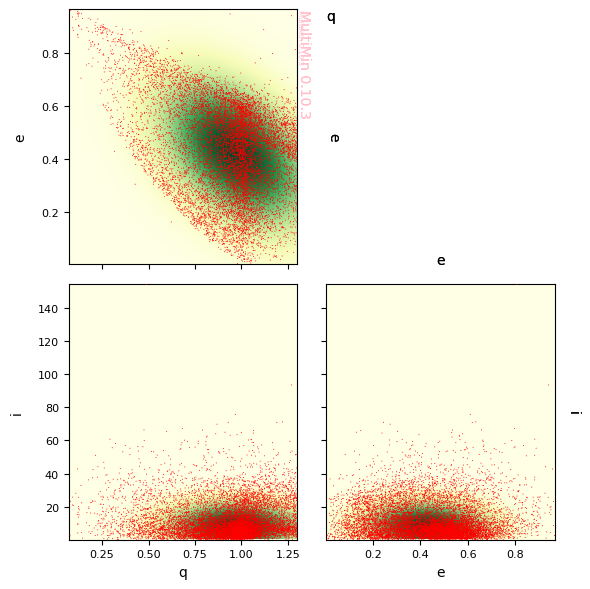

In [23]:
properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Domain: [[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]]
Log-likelihood per point (-log L/N): 338.339532258605


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 6.792531967163086 seconds


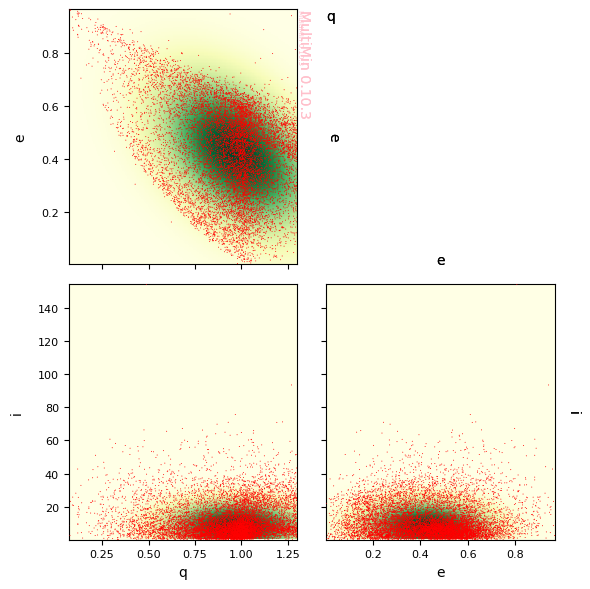

In [24]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=5, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(progress="tqdm")
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the MoG is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the MoG in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [25]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **MultiPlot** (scatter on pairwise panels):

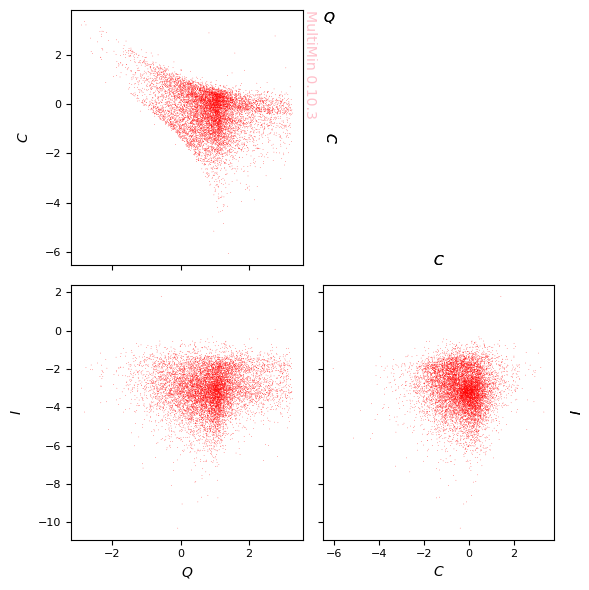

In [26]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.MultiPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

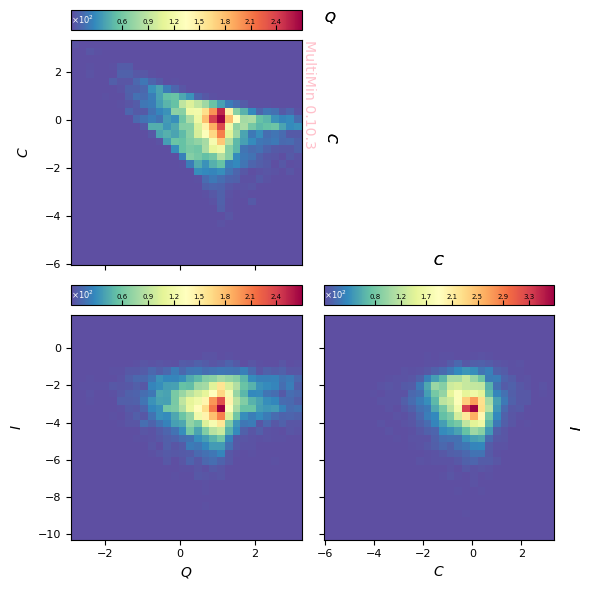

In [27]:
G=mn.MultiPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.sample_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [28]:
F=mn.FitMoG(data=udata, ngauss=1)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.007302012242295


The fitter holds an initial MoG that will be optimized:

In [29]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.5, 0.5, 0.5]]
    Standard deviations (σ): [[1.0000000000000002, 1.0000000000000002, 1.0000000000000002]]
    Correlation coefficients (ρ): [[0.5, 0.5, 0.5]]

    Covariant matrices (Σ): 
        [[[1.0000000000000004, 0.5000000000000002, 0.5000000000000002], [0.5000000000000002, 1.0000000000000004, 0.5000000000000002], [0.5000000000000002, 0.5000000000000002, 1.0000000000000004]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000004, 0.5000000000000002, 0.5000000000000002, 1.0000000000000004, 0.5000000000000002, 1.0000000000000004]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000002, 1.0000000000000002, 1.000

Run the minimization:

In [30]:
t = mn.Util.el_time(0)
F.fit_data(verbose=False,progress="tqdm")
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.17062687873840332 seconds
Elapsed time since last call: 170.821 ms
-log(L)/N = 3.968224954498121


Inspect the fitted MoG:

In [31]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8611952339109257, -0.3223210972557515, -3.072414191141828]]
    Standard deviations (σ): [[0.8562841242177158, 0.8686232477416072, 1.0666947060586258]]
    Correlation coefficients (ρ): [[-0.32088071022252285, 0.04944287953323179, -0.054155194568558995]]

    Covariant matrices (Σ): 
        [[[0.7332225013873006, -0.23866731698615462, 0.04516081676126489], [-0.23866731698615462, 0.7545063465171774, -0.05017781070669197], [0.04516081676126489, -0.05017781070669197, 1.137837595933498]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8611952339109257, -0.3223210972557515, -3.072414191141828, 0.7332225013873006, -0.23866731698615462, 0.04516081676126489, 0.7545063465171774, -0.05017781070669197, 1.137837595933498]
        With std. and correl

Plot the fit result (fitted sample + data scatter):

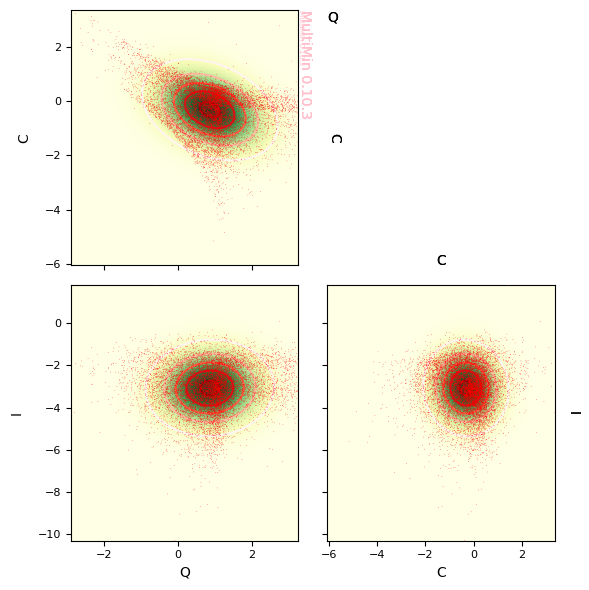

In [32]:
properties=["Q","C","I"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
cargs=dict()
G=F.plot_fit(properties=properties,sargs=sargs,cargs=cargs,pargs=pargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [33]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [34]:
F=mn.FitMoG(f"gallery/{figprefix}_fit-single.pkl")
print(F.mog)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 3.968224954498121
Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8611952339109257, -0.3223210972557515, -3.072414191141828]]
    Standard deviations (σ): [[0.8562841242177158, 0.8686232477416072, 1.0666947060586258]]
    Correlation coefficients (ρ): [[-0.32088071022252285, 0.04944287953323179, -0.054155194568558995]]

    Covariant matrices (Σ): 
        [[[0.7332225013873006, -0.23866731698615462, 0.04516081676126489], [-0.23866731698615462, 0.7545063465171774, -0.05017781070669197], [0.04516081676126489, -0.05017781070669197, 1.137837595933498]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8611952339109257, -0.322321097255751

Fit with two Gaussian components for a better likelihood:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.007302012242295


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.810664176940918 seconds
Elapsed time since last call: 810.821 ms
-log(L)/N = 3.8771646207505315
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.2815239282061717, 0.7184760717938283]
    Number of variables: 3
    Averages (μ): [[0.4520980322116629, 0.43816533612621666, -3.486175344978731], [1.0021795387000403, -0.6029854025341332, -2.9164516850866744]]
    Standard deviations (σ): [[0.8679443616991143, 0.5709994292390775, 1.1765661752402576], [0.804865464498295, 0.787432699570172, 0.9728823916228647]]
    Correlation coefficients (ρ): [[-0.8078769238558724, -0.3191015104559404, 0.3353280723959624], [-0.03332295372733385, 0.12618199608358838, 0.017292056793106747]]

    Covariant matrices (Σ): 
        [[[0.7533274150052829, -0.40038035798218025, -0.3258645408373567], [-0.40038035798218025, 0.3260403481913523, 0.22527964100812325], [-0.3258645408373567, 0.22527964100812325, 1.3843079647194887]], [[0.6478084159

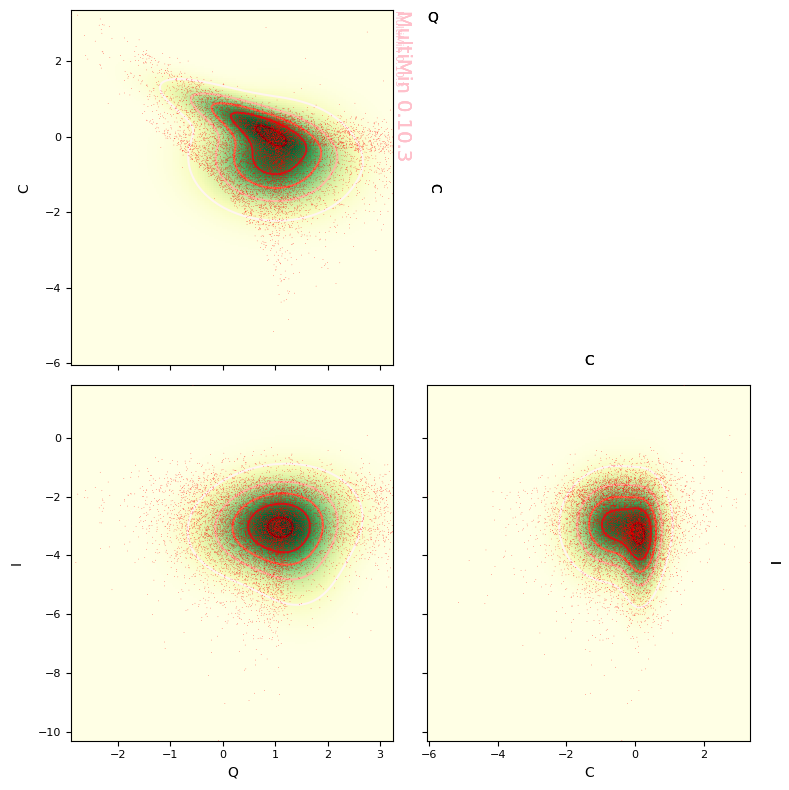

In [35]:
F=mn.FitMoG(data=udata, ngauss=2)

mn.Util.el_time(0)
F.fit_data(progress="tqdm")
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)

G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.007302012242295


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 0.8554120063781738 seconds
Elapsed time since last call: 855.501 ms
-log(L)/N = 3.877147717282996
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.28204813455764954, 0.7179518654423505]
    Number of variables: 3
    Averages (μ): [[0.45388932344219185, 0.4373201712325369, -3.485733530096843], [1.0019634690812593, -0.6034853332936004, -2.9162891160143767]]
    Standard deviations (σ): [[0.8681648224491121, 0.5707157557916792, 1.1759347927398196], [0.8048892979736519, 0.787430260130191, 0.9730837463554507]]
    Correlation coefficients (ρ): [[-0.8077006681641362, -0.31800776051931356, 0.33459517297988683], [-0.03341834879513117, 0.12634892430125189, 0.017419262403439495]]

    Covariant matrices (Σ): 
        [[[0.7537101589380983, -0.4001957654350172, -0.3246557828898037], [-0.4001957654350172, 0.3257164739088676, 0.22455502285295204], [-0.3246557828898037, 0.22455502285295204, 1.3828226367760426]], [[0.64784678

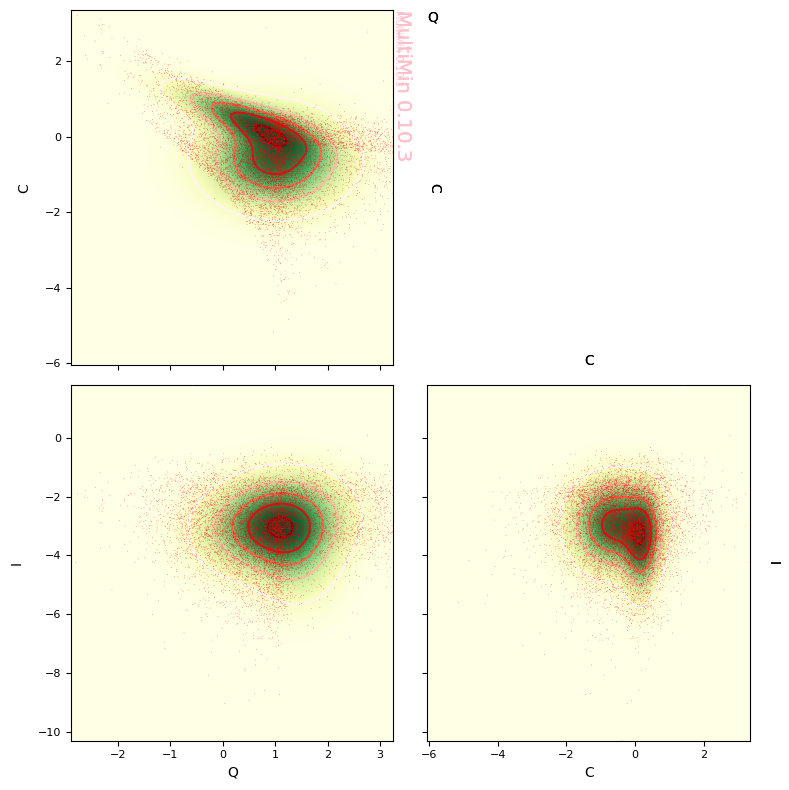

In [36]:
F=mn.FitMoG(data=udata, ngauss=2)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.007302012242295


Minimizing: 0it [00:00, ?it/s]

FitMoG.fit_data executed in 11.12644910812378 seconds
Elapsed time since last call: 11.1268 s
-log(L)/N = 3.717893598558479
Composition of ngauss = 5 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.10923840206240125, 0.32104616476931247, 0.12208807549927081, 0.2158728825587169, 0.23175447511029865]
    Number of variables: 3
    Averages (μ): [[1.5537696691800642, -0.7642853579310701, -3.5867820123838143], [0.9941407083460478, -0.5895108538633007, -2.892751166995981], [0.5276612594413327, 0.530016278488928, -3.7085572960829496], [1.3739590218461197, 0.11534468216857827, -3.1211123820017987], [-0.04934777072104664, -0.4341166177068566, -2.7037529116495937]]
    Standard deviations (σ): [[0.8513254288491199, 0.7390163642478903, 1.5727784122928157], [0.364080673735288, 0.6028569079483432, 0.8994076536924221], [0.6014173003304945, 0.37948098160287186, 1.1266073815210278], [0.8288002460037102, 0.2807837647976319, 0.798348240350655], [0.7450051523690069, 1.2413658585391

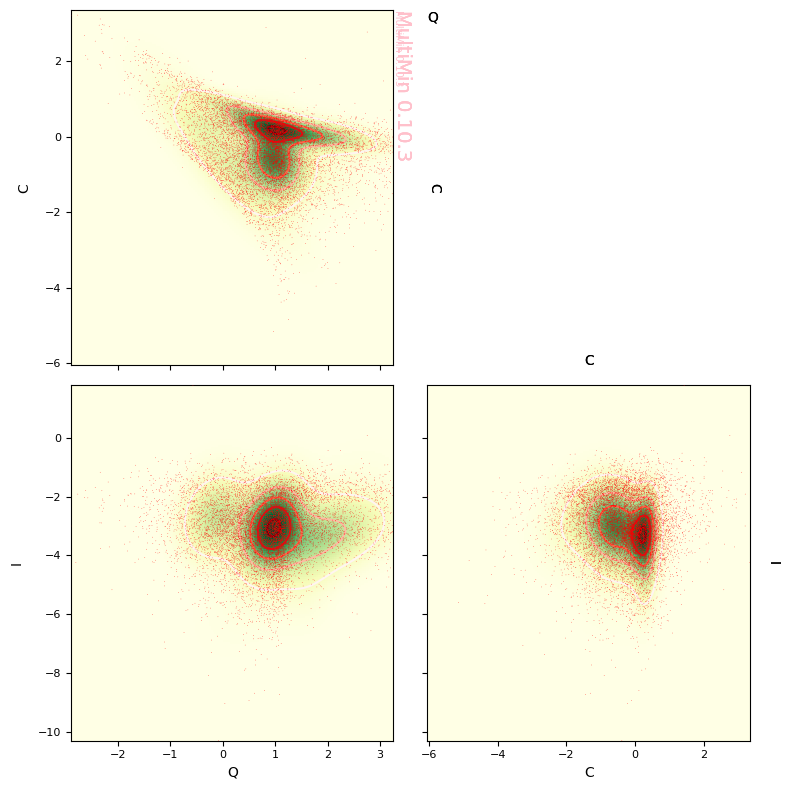

In [37]:
F=mn.FitMoG(data=udata, ngauss=5)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted MoG and comparing to the data:

MixtureOfGaussians.rvs executed in 0.4889688491821289 seconds


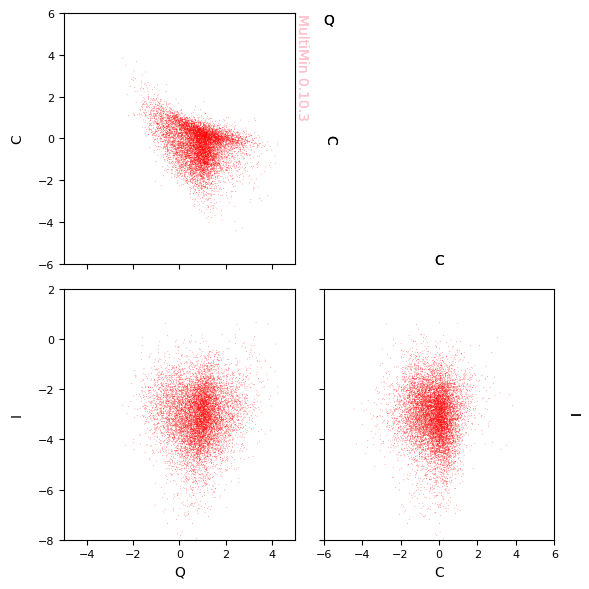

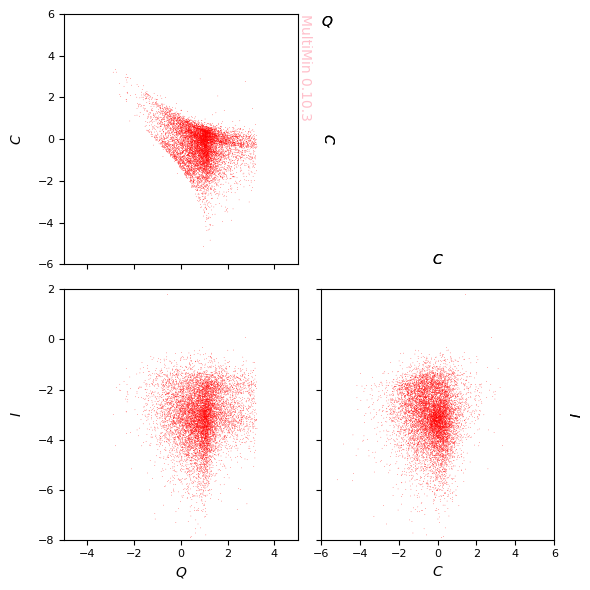

In [38]:
F.mog.plot_sample(N=len(F.data),
                  figsize=3,
                  properties=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")

properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

We can also check the original distribution:

In [39]:
scales=[1.35,1.00,180.0]
usample = F.mog.rvs(len(udata))
rsample=np.zeros_like(usample)
for i in range(len(usample)):
    rsample[i] = mn.Util.t_if(usample[i], scales, mn.Util.u2f)

MixtureOfGaussians.rvs executed in 0.49824094772338867 seconds


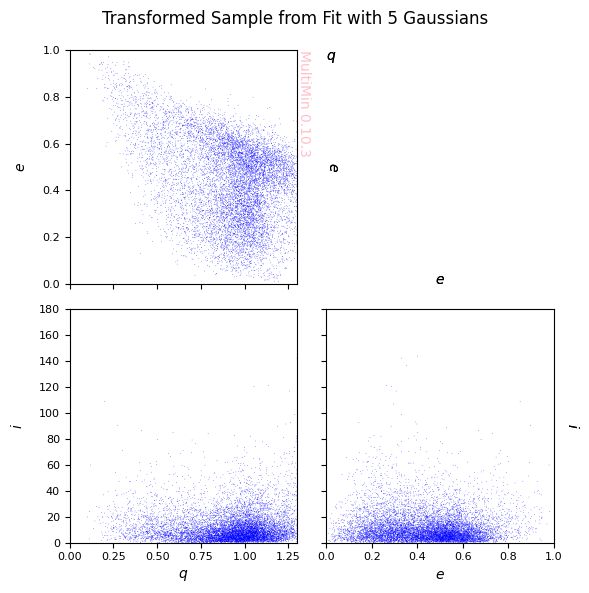

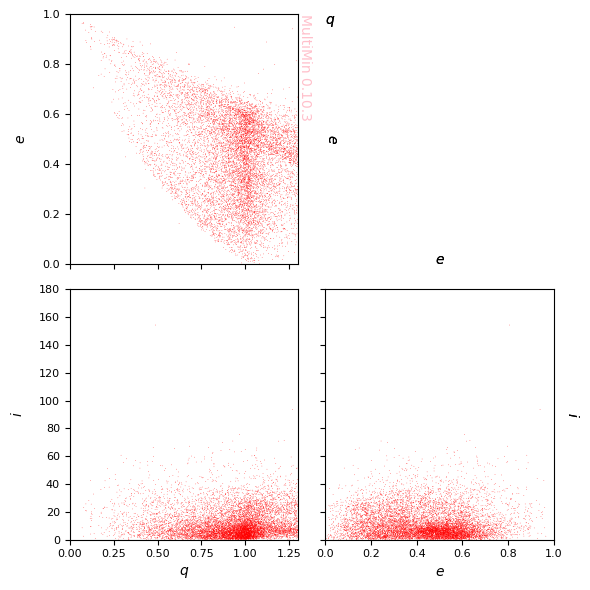

In [40]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='b')
scatter_transformed=Gt.sample_scatter(rsample,**sargs)
Gt.fig.suptitle(f"Transformed Sample from Fit with {F.ngauss} Gaussians")
Gt.fig.tight_layout()
Gt.fig.savefig(f"gallery/{figprefix}_sample_from_fit_ngauss_qei.png")

Go=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter_original=Go.sample_scatter(data_neas_qei,**sargs)

In [41]:
function, mog = F.mog.get_function(properties=properties)

from multimin import Util

def mog(X):

    mu1_q = 1.55377
    mu1_e = -0.764285
    mu1_i = -3.586782
    mu1 = [mu1_q, mu1_e, mu1_i]
    Sigma1 = [[0.724755, -0.067001, 0.898725], [-0.067001, 0.546145, -0.166825], [0.898725, -0.166825, 2.473632]]
    n1 = Util.nmd(X, mu1, Sigma1)

    mu2_q = 0.994141
    mu2_e = -0.589511
    mu2_i = -2.892751
    mu2 = [mu2_q, mu2_e, mu2_i]
    Sigma2 = [[0.132555, -0.052857, 0.092047], [-0.052857, 0.363436, -0.096696], [0.092047, -0.096696, 0.808934]]
    n2 = Util.nmd(X, mu2, Sigma2)

    mu3_q = 0.527661
    mu3_e = 0.530016
    mu3_i = -3.708557
    mu3 = [mu3_q, mu3_e, mu3_i]
    Sigma3 = [[0.361703, -0.190999, -0.134239], [-0.190999, 0.144006, 0.123524], [-0.134239, 0.123524, 1.269244]]
    n3 = Util.nmd(X, mu3, Sigma3)

    mu4_q = 1.373959
    mu4_e = 0.115345
    mu4_i = -3.121112
    mu4 = [mu4_q, mu4_e, mu4_i]
    Sigma4 = [[0.68691, -0.119446, 0.140491], [-0.119446, 0.07884, 0.036287], [0.140491, 0.036287, 0.63736]]
    n4 = Util.nmd(X

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga